## Distance Matrix Generator for Vertex & Edge Diagram of QEH

In [1]:
import itertools, re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

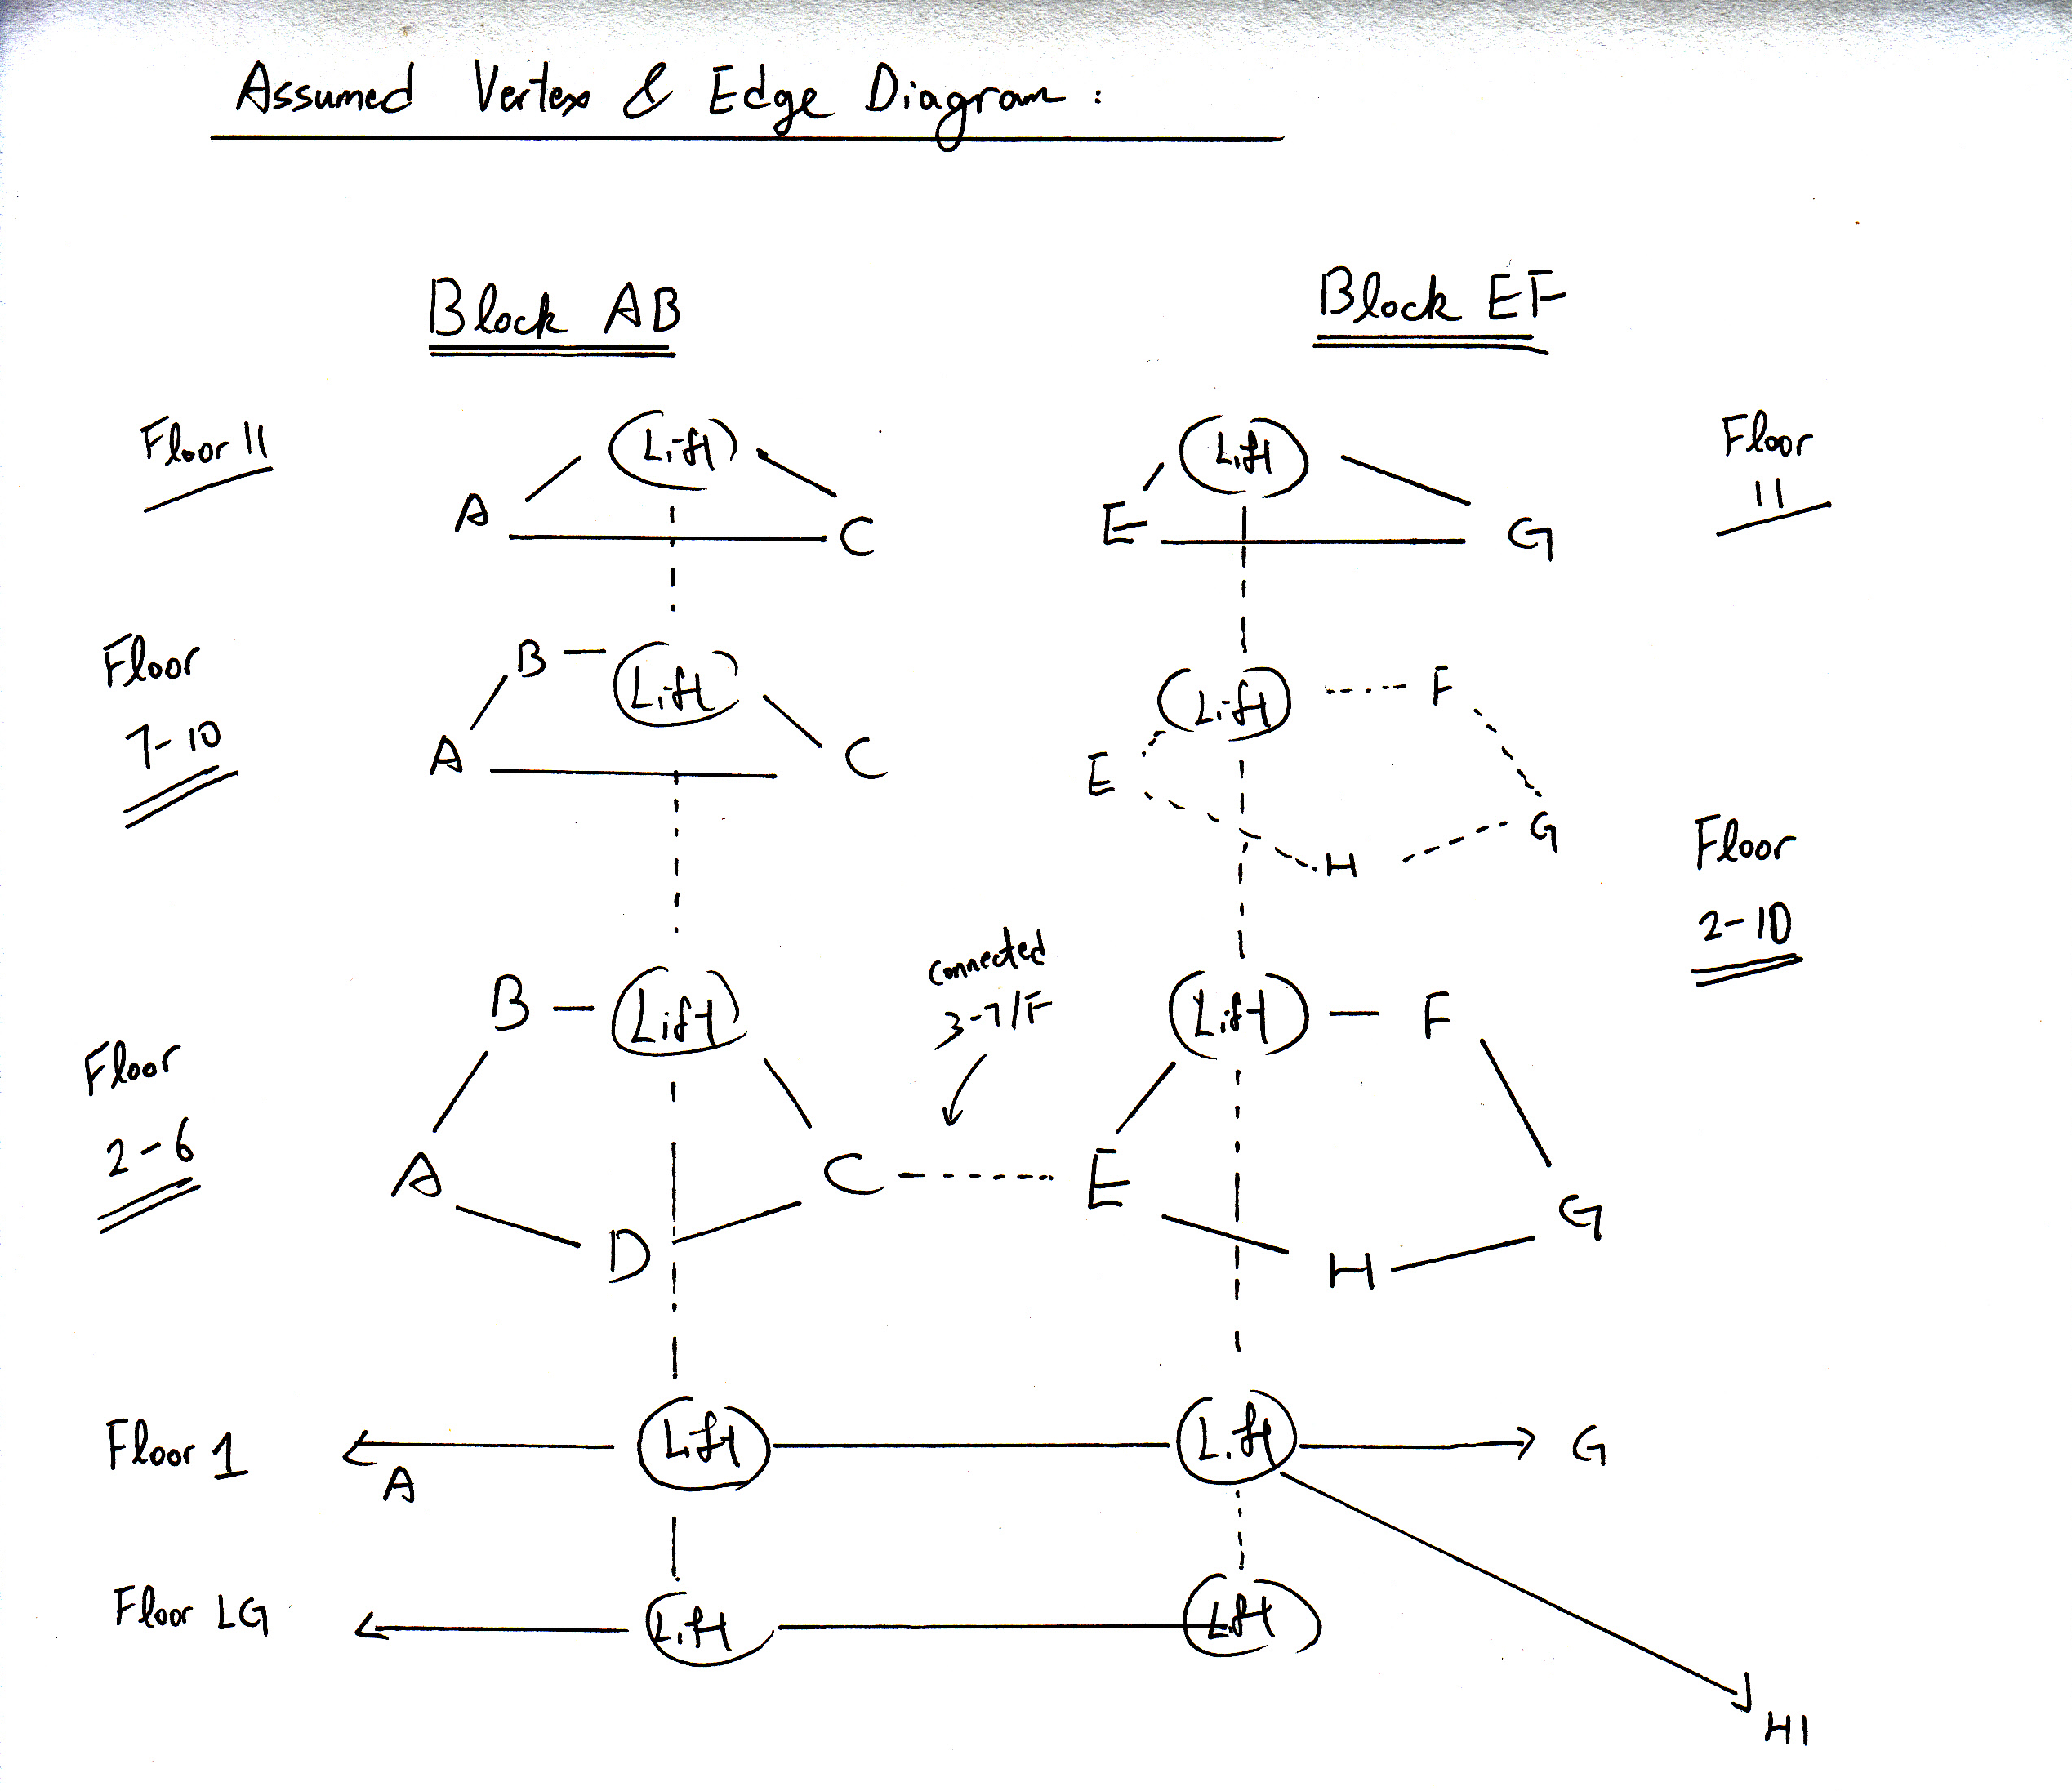

Brief Description: This code is for creating a shortest time-distance matrix between every ward location. The input is the table of lift-waiting time (for taking lift up & taking lift down) in csv format. The output for the final usable function calls will be the shortest time-distance and the shortest path between every pair of source and destination ward location.

P.S.: The assumed vertex & edge diagram is as above. It is assumed it takes 2 units of time between each connected ward at same floor, 10 units of time between Ward C and Ward E of 3-7/F, 5 units of time between block AB and block EF at 1/F & LG/F and 1 unit of time per floor once in a lift.

In [2]:
blockAB_liftwait = pd.read_csv('LiftWaitTime_BlockAB.csv')
blockEF_liftwait = pd.read_csv('LiftWaitTime_BlockEF.csv')

(The commented code below is for generating another random lift waiting time table different from the one imported. Use different seed value to create different random lift waiting time) 

In [3]:
'''
def create_hypothetical_liftwait(liftwait_df, liftup_seed, liftdown_seed):
    np.random.seed(liftup_seed)
    floorwait_up = np.sort(np.random.randint(low=5, high=30, size=9, dtype=int))[::-1]
    lobbywait_up = np.random.randint(low=10, high=20, size=3, dtype=int)
    wait_up = np.concatenate((lobbywait_up,floorwait_up), axis=None)
    liftwait_df.loc[:, 'LiftWaitTime(Up)'] = pd.Series(wait_up)
    
    np.random.seed(liftdown_seed)
    floorwait_down = np.sort(np.random.randint(low=5, high=30, size=10, dtype=int))[::-1]
    lobbywait_down = np.random.randint(low=10, high=20, size=2, dtype=int)
    wait_down = np.concatenate((np.empty(1).fill(np.nan),lobbywait_down,floorwait_down), axis=None)
    liftwait_df.loc[:, 'LiftWaitTime(Down)'] = pd.Series(wait_down)
    
    return liftwait_df

blockAB_liftwait = create_hypothetical_liftwait(blockAB_liftwait, 20, 15)
blockEF_liftwait = create_hypothetical_liftwait(blockEF_liftwait, 100, 55)

blockAB_liftwait.to_csv('LiftWaitTime_BlockAB.csv', index=False, encoding='utf-8', mode='w+')
blockEF_liftwait.to_csv('LiftWaitTime_BlockEF.csv', index=False, encoding='utf-8', mode='w+')

'''

"\ndef create_hypothetical_liftwait(liftwait_df, liftup_seed, liftdown_seed):\n    np.random.seed(liftup_seed)\n    floorwait_up = np.sort(np.random.randint(low=5, high=30, size=9, dtype=int))[::-1]\n    lobbywait_up = np.random.randint(low=10, high=20, size=3, dtype=int)\n    wait_up = np.concatenate((lobbywait_up,floorwait_up), axis=None)\n    liftwait_df.loc[:, 'LiftWaitTime(Up)'] = pd.Series(wait_up)\n    \n    np.random.seed(liftdown_seed)\n    floorwait_down = np.sort(np.random.randint(low=5, high=30, size=10, dtype=int))[::-1]\n    lobbywait_down = np.random.randint(low=10, high=20, size=2, dtype=int)\n    wait_down = np.concatenate((np.empty(1).fill(np.nan),lobbywait_down,floorwait_down), axis=None)\n    liftwait_df.loc[:, 'LiftWaitTime(Down)'] = pd.Series(wait_down)\n    \n    return liftwait_df\n\nblockAB_liftwait = create_hypothetical_liftwait(blockAB_liftwait, 20, 15)\nblockEF_liftwait = create_hypothetical_liftwait(blockEF_liftwait, 100, 55)\n\nblockAB_liftwait.to_csv('Lif

In [4]:
blockAB_liftwait

,Floor,LiftWaitTime(Up),LiftWaitTime(Down)
0,LG,16.0,NaN
1,G,18.0,11.0
2,1,15.0,17.0
3,2,27.0,28.0
4,3,25.0,27.0
5,4,20.0,26.0
6,5,16.0,26.0
7,6,14.0,17.0
8,7,12.0,16.0
9,8,8.0,13.0


In [5]:
blockEF_liftwait

,Floor,LiftWaitTime(Up),LiftWaitTime(Down)
0,LG,12.0,NaN
1,G,15.0,18.0
2,1,12.0,17.0
3,2,29.0,28.0
4,3,28.0,27.0
5,4,25.0,21.0
6,5,21.0,18.0
7,6,20.0,13.0
8,7,15.0,12.0
9,8,13.0,10.0


Function (form_ward) creates the ward nodes, such as D6, E10, ALG, etc. The complete list of wards is stored in ward_list

In [6]:
def form_wards(blocks, start_floor, end_floor):
    blocklist = blocks
    floorlist = [floor for floor in range(start_floor,end_floor+1)]

    unique_combinations = []

    for block in range(len(blocklist)):
        for floor in range(len(floorlist)):
            unique_combinations.append(blocklist[block]+str(floorlist[floor]))

    return unique_combinations

In [7]:
AB_2_6 = form_wards (["A", "B", "C","D"],2,6)
AB_7_10 = form_wards (["A", "B", "C"],7,10)
AB_others = ['A11','C11','ALG','A1']
EF_2_10 = form_wards (["E", "F", "G","H"],2,10)
EF_others = ['E11','G11','G1','H1']
ward_list = list(itertools.chain(AB_2_6,AB_7_10,AB_others,EF_2_10,EF_others))
ward_list.sort()

Function (form_liftfloors) creates the lift lobby nodes at each floor, named as follows: 
Lift_AB_5 represents lift lobby node at Block AB 5/F. The complete list of lift lobbies is stored in liftfloor_list

In [8]:
def form_liftfloors (blockprefix, start_floor, end_floor, add_floorlist):
    floorlist = list(map(str,list(range(start_floor, end_floor+1))))
    floorlist.extend(add_floorlist)
    prefixedlist=[blockprefix + floor for floor in floorlist]
    return prefixedlist

In [9]:
liftfloor_list = form_liftfloors (blockprefix = 'Lift_AB_', start_floor = 1, end_floor = 11, add_floorlist = ['G','LG'])
liftfloor_list.extend(form_liftfloors (blockprefix = 'Lift_EF_', start_floor = 1, end_floor = 11, add_floorlist = ['G','LG']))

In [10]:
nodelist = ward_list + liftfloor_list

EdgeList will store the complete set of directly connected edges. The edges are directed (single direction only from source node to destination node)

Class WardtoWard is template class for creating the edges between ward & ward.
Class WardtoLift is template class for creating the edges between ward & lift lobby.
The edge weights are assumed to be 2.

In [11]:
edgelist = pd.DataFrame(columns = ['source', 'destination', 'weight'])

In [12]:
class WardtoWard:
    def __init__(self, allowed_blocks, allowed_floors, edge_weight):
        self.allowed_blocks = allowed_blocks
        self.allowed_floors = allowed_floors
        self.edge_weight = edge_weight
        
    def rule(self, source_node, destination_node):
        patternstring ='^{block}({floors}$)'.format(block = self.allowed_blocks, floors = self.allowed_floors)
        #print(patternstring)
        pattern = re.compile(patternstring)
        if pattern.match(source_node) and pattern.match(destination_node):
            if pattern.match(source_node).group(1) == pattern.match(destination_node).group(1):
                s1 = pd.Series([source_node, destination_node, self.edge_weight], index=['source','destination','weight'])
                s2 = pd.Series([destination_node, source_node, self.edge_weight], index=['source','destination','weight'])
                undirected_df = pd.DataFrame([s1, s2])
                return undirected_df 
        else:
            return None

In [13]:
class WardtoLift:
    def __init__(self, allowed_blocks, allowed_floors,tower, edge_weight):
        self.allowed_blocks = allowed_blocks
        self.allowed_floors = allowed_floors
        self.tower = tower
        self.edge_weight = edge_weight
        
    def rule(self, source_node, destination_node):
        lift_patternstring = 'Lift_(AB|EF)_([0-9]+|G|LG)'
        ward_patternstring =r'\b{block}({floors})\b'.format(block = self.allowed_blocks, floors = self.allowed_floors)
        lift_pattern = re.compile(lift_patternstring)
        ward_pattern = re.compile(ward_patternstring)
        combined_node = source_node+'/'+destination_node
        if ward_pattern.match(combined_node) and len(lift_pattern.findall(combined_node))==1:
            if ward_pattern.search(combined_node).group(1) == lift_pattern.search(combined_node).group(2) and lift_pattern.search(combined_node).group(1)==self.tower:
                s1 = pd.Series([source_node, destination_node, self.edge_weight], index=['source','destination','weight'])
                s2 = pd.Series([destination_node, source_node, self.edge_weight], index=['source','destination','weight'])
                undirected_df = pd.DataFrame([s1, s2])
                return undirected_df 
        else:
            return None

The rule instances guides the rules for creating connections between nodes. 

For WardtoLift rules (allowed_blocks = '[B|C]',allowed_floors = '([2-9]|10)') means Ward B and Ward C is connected to lift lobby at 2-10/F.

For WardtoWard rules (allowed_blocks = '[A|B]',allowed_floors = '([2-9]|10)') means Ward A and Ward B is directly adjacent at 2-10/F.

In [14]:
rule_ABLift_2_10 = WardtoLift(allowed_blocks = '[B|C]',allowed_floors = '([2-9]|10)', edge_weight = 2, tower = 'AB')
rule_ABLift_11 = WardtoLift(allowed_blocks = '[A|C]',allowed_floors = '(11)', edge_weight = 2, tower = 'AB')
rule_ABLift_LG_1 = WardtoLift(allowed_blocks = '[A]',allowed_floors = '(LG|1)', edge_weight = 2, tower = 'AB')
rule_EFLift_2_10 = WardtoLift(allowed_blocks = '[E|F]',allowed_floors = '([2-9]|10)', edge_weight = 2, tower = 'EF')
rule_EFLift_11 = WardtoLift(allowed_blocks = '[E|G]',allowed_floors = '(11)', edge_weight = 2, tower = 'EF')
rule_EFLift_1 = WardtoLift(allowed_blocks = '[G]',allowed_floors = '(1)', edge_weight = 2, tower = 'EF')

In [15]:
rule_AB_2_10 = WardtoWard(allowed_blocks = '[A|B]',allowed_floors = '([2-9]|10)', edge_weight = 2)
rule_AD_2_6 = WardtoWard(allowed_blocks = '[A|D]',allowed_floors = '([2-6])', edge_weight = 2)
rule_CD_2_6 = WardtoWard(allowed_blocks = '[C|D]',allowed_floors = '([2-6])', edge_weight = 2)
rule_AC_7_11 = WardtoWard(allowed_blocks = '[A|C]',allowed_floors = '([7-9]|10|11)', edge_weight = 2)
rule_EH_2_10 = WardtoWard(allowed_blocks = '[E|H]',allowed_floors = '([2-9]|10)', edge_weight = 2)
rule_GH_2_10 = WardtoWard(allowed_blocks = '[G|H]',allowed_floors = '([2-9]|10)', edge_weight = 2)
rule_FG_2_10 = WardtoWard(allowed_blocks = '[F|G]',allowed_floors = '([2-9]|10)', edge_weight = 2)
rule_EG_10_11 = WardtoWard(allowed_blocks = '[E|G]',allowed_floors = '(11)', edge_weight = 2)
rule_CE_3_7 = WardtoWard(allowed_blocks = '[C|E]',allowed_floors = '([3-7])', edge_weight = 10)

In [16]:
wardconnects = [rule_AB_2_10,rule_AD_2_6,rule_CD_2_6,rule_AC_7_11,rule_EH_2_10,rule_GH_2_10,rule_FG_2_10,rule_EG_10_11,rule_CE_3_7]
wardlift = [rule_ABLift_2_10,rule_ABLift_11,rule_ABLift_LG_1,rule_EFLift_2_10,rule_EFLift_11,rule_EFLift_1]
wardliftconnects = wardconnects+wardlift

Function (addto_edgelist) creates the bi-directional edges for every node combinations based on the above rules

In [17]:
def addto_edgelist(wardpair_tuple, ward_connects):
    for wardrule in ward_connects:
        undirected_edges = wardrule.rule(*wardpair_tuple)
        if undirected_edges is not None:
            global edgelist
            edgelist = pd.concat([edgelist, undirected_edges], axis=0,ignore_index=True)

In [18]:
comb = itertools.combinations(nodelist, 2)
for wardpair in list(comb):
    addto_edgelist(wardpair, wardliftconnects)

Class LifttoLift is template class for creating the edges between lift lobbies of different floors.

The edgeweight is directional. Traversing from e.g. Block AB 2/F->10/F has different time cost as 10/F->2/F because it may take a lot more time waiting for lift at 2/F than 10/F. The lift-wait time-distance cost is taken from the liftwait table. It is assumed the edge traversal cost = liftwait cost + travel cost per floor * number of floors. The travel cost per floor is assumed to be 1 unit.

Function (addto_edgelist) creates the uni-directional edges for every lift lobby permutations based on the above rules.

In [19]:
class LifttoLift:
    def __init__(self, tower, liftwait_df, floor_travel_time):
        self.tower = tower
        self.matrix = liftwait_df
        self.floortraveltime = floor_travel_time
        
    def rule(self, source_node, destination_node):
        patternstring ='Lift_(AB|EF)_([0-9]+|G|LG)'
        pattern = re.compile(patternstring)
        if pattern.match(source_node) and pattern.match(destination_node):
            if pattern.match(source_node).group(1) == pattern.match(destination_node).group(1) == self.tower:
                sourcefloor = pattern.match(source_node).group(2)
                destinationfloor = pattern.match(destination_node).group(2)
                sourcerank = self.matrix.index[self.matrix['Floor']==sourcefloor].tolist()[0]
                destinationrank = self.matrix.index[self.matrix['Floor']==destinationfloor].tolist()[0]
                floorchange = destinationrank-sourcerank
                if floorchange > 0:
                    edgeweight = self.matrix.loc[sourcerank,'LiftWaitTime(Up)'] + self.floortraveltime*floorchange
                elif floorchange < 0:
                    edgeweight = self.matrix.loc[sourcerank,'LiftWaitTime(Down)'] + self.floortraveltime*abs(floorchange)
                series = pd.Series([source_node, destination_node, edgeweight], index=['source','destination','weight'])
                directed_df = pd.DataFrame([series])
                return directed_df 
        else:
            return None

In [20]:
rule_Lift_AB = LifttoLift(tower = 'AB', liftwait_df = blockAB_liftwait , floor_travel_time = 1)
rule_Lift_EF = LifttoLift(tower = 'EF', liftwait_df = blockEF_liftwait , floor_travel_time = 1)

In [21]:
liftconnects = [rule_Lift_AB, rule_Lift_EF]

In [22]:
def addfloor_edgelist(floorpair_tuple, floor_connects):
    for liftrule in floor_connects:
        directed_edges = liftrule.rule(*floorpair_tuple)
        if directed_edges is not None:
            global edgelist
            edgelist = pd.concat([edgelist, directed_edges], axis=0,ignore_index=True)

In [23]:
perm = itertools.permutations(nodelist, 2)
for nodepair in list(perm):
    addfloor_edgelist(nodepair, liftconnects)

Edgelist is the completed directed graph.
The directed graph is imported to NetworkX.

In [24]:
# pd.options.display.max_rows = 512
# edgelist

The directed graph is stored in variable "graph". 

The following attributes of the graph can be accessed using the following commands:

Number of nodes: graph.number_of_nodes()

Number of edges: graph.number_of_edges()

Complete list of nodes: graph.nodes(data=True)

Complete list of edges: graph.edges(data=True)

The "nature" attribute of nodes denote whether node is ward or lift lobby.

The "weight" attribute of edges denote the time-distance cost of each edge

In [25]:
graph = nx.from_pandas_edgelist(edgelist, source = "source", target = "destination", edge_attr = "weight", create_using = nx.DiGraph())

In [26]:
labels = 'unspecified'
nx.set_node_attributes(graph, labels, 'nature')
for ward in ward_list:
    graph.add_node(ward)
    graph.nodes[ward]['nature'] = 'ward'
for liftfloor in liftfloor_list:
    graph.add_node(liftfloor)
    graph.nodes[liftfloor]['nature'] = 'lift_lobby'

Function (add_doubleedges) allows adding additional connections.

In [27]:
def add_doubleedges(graph, source, destination, edgeweight):
    graph.add_edge(source, destination, weight = edgeweight)
    graph.add_edge(destination, source, weight = edgeweight)
add_doubleedges(graph, 'Lift_AB_1', 'Lift_EF_1', edgeweight = 5)
add_doubleedges(graph, 'Lift_AB_LG','Lift_EF_LG', edgeweight = 5)
add_doubleedges(graph, 'Lift_EF_1', 'H1', edgeweight = 5)

The following are the output functions:

Function (get_shortest_path) returns the shortest path in list format.

Function (get_shortest_path_length) returns the shortest time-distance cost between the selected pair of vertices.

The distance are calculated using Dijkstra's Algorithm.

Example:

get_shortest_path_length(graph,'A10','E5') will return the shortest time-distance between ward A10 and E5: 31 units

get_shortest_path(graph,'A10','E5') will return the actual path: ['A10', 'B10', 'Lift_AB_10', 'Lift_AB_5', 'C5', 'E5']


In [28]:
def get_shortest_path(graph, source, destination):
    shortest_path = nx.dijkstra_path(graph, source=source, target=destination, weight='weight')
    return shortest_path
def get_shortest_path_length(graph, source, destination):
    shortest_path = nx.dijkstra_path_length(graph, source=source, target=destination, weight='weight')
    return shortest_path

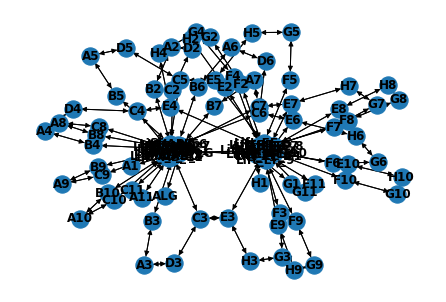

In [29]:
nx.draw(graph, with_labels=True, font_weight='bold')
plt.show()

In [30]:
get_shortest_path(graph,'A1','E2')

['A1', 'Lift_AB_1', 'Lift_EF_1', 'Lift_EF_2', 'E2']

In [31]:
get_shortest_path_length(graph,'A1','E2') 

22.0

In [32]:
# def get_travel_time(wardA,wardB,edgelist):
#     travel_route=get_shortest_path(graph,wardA,wardB)
#     time_consume=0
#     for i in range(len(travel_route)-1):
#         if len(edgelist[(edgelist['source']==travel_route[i])&(edgelist['destination']==travel_route[i+1])])==0:
#             time_consume+=0
#         else:
#             time_consume+=edgelist[(edgelist['source']==travel_route[i])&(edgelist['destination']==travel_route[i+1])]['weight'].values[0]
#     return time_consume

In [33]:
# demands=[]
# for i in range(len(ward_list)):
#     demands.append(20)

## Input Part

In [34]:
agg_input=pd.read_csv('sub20230114_agg.csv')

In [35]:
#location of each portable team
vehicle_depot=['H1','H1','H1','H1','H1']

In [36]:
# rest available time of each team(mins)
capacities = [120,120,120,120,120]  

In [37]:
#time needed to finish each requests (mins)
time_per_demand = 2

In [38]:
#allowed overtime(mins)
allowed_ot=20

## Main part for ACO

In [39]:
#list of all wards
ward_list=['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','B2','B3','B4','B5','B6','B7','B8','B9','B10','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','D2','D3','D4','D5','D6','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','F2','F3','F4','F5','F6','F7','F8','F9','F10','G1','G2','G3','G4','G5','G6','G7','G8','G9','G10','G11','H1','H2','H3','H4','H5','H6','H7','H8','H9','H10']

In [40]:
#travel time needed from ward i to j
distances=[]
for i in range(len(ward_list)):
    distance=[]
    for j in range(len(ward_list)):
        distance.append(get_shortest_path_length(graph,ward_list[i],ward_list[j]))
    distances.append(distance)

In [41]:
#index the wards list
depot=[]
for ve_depot in vehicle_depot:
    depot.append(ward_list.index(ve_depot))

In [58]:
#demands of each ward(auto-generated from the agg_input)
demands=[]
for req_ward in ward_list:
    try:
        demands.append(agg_input[agg_input['Ward']==req_ward]['Number of Scans'].values[0])
    except:
        demands.append(0)

In [44]:
# Set objecive function
r, alpha, beta, k = 10, 1, 3, 20

# Set up elements in the objective function
def reward(solution, r):
    reward = 0
    for vehicle in range(len(solution['requests'])):
        reward += solution['requests'][vehicle] * r
    return reward

def travel_time_cost(solution, alpha):
    travel_time_cost = 0
    for vehicle in range(len(solution['travelling_time'])):
        travel_time_cost += solution['travelling_time'][vehicle] * alpha
    return travel_time_cost

# def uneven_caseload_cost(solution, beta):
#     uneven_caseload_cost = 0
#     for vehicle in range(len(solution['requests'])):
#         uneven_caseload_cost += abs(solution['requests'][vehicle] - np.mean(solution['requests'])) * beta
#     return uneven_caseload_cost

#def overtime_underload_cost(solution, k, max_overtime, max_underload):
def overtime_underload_cost(solution, k, max_overtime):
    overtime_underload_cost = 0
    for vehicle in range(len(solution['overtime'])):
#         if (solution['overtime'][vehicle] <= max_overtime) and (solution['underload'][vehicle] <= max_underload):overtime_underload_cost += 0
#         else:overtime_underload_cost += np.max([k * (solution['overtime'][vehicle] - max_overtime) ** 2, k * (solution['underload'][vehicle] - max_underload) ** 2])
        if (solution['overtime'][vehicle] <= max_overtime) :overtime_underload_cost += 0
        else:overtime_underload_cost += [k * (solution['overtime'][vehicle] - max_overtime) ** 2]
    return overtime_underload_cost

# Set up the objective function
# def objective_function(solution, r, alpha, beta, k, max_overtime, max_underload):
def objective_function(solution, r, alpha, beta, k, max_overtime):
    #objective_function = reward(solution, r) - travel_time_cost(solution, alpha) - uneven_caseload_cost(solution, beta) - overtime_underload_cost(solution, k, max_overtime, max_underload)
    objective_function = reward(solution, r) - travel_time_cost(solution, alpha) -  overtime_underload_cost(solution, k, max_overtime)
    return objective_function

In [60]:
    #Main part
    from ortools.constraint_solver import routing_enums_pb2
    from ortools.constraint_solver import pywrapcp
    import numpy as np
    import random
    import time
    
    # set parameters and data info needed
    num_vehicles = len(vehicle_depot)  # num of available portable teams
    
    #for one team 
    depot = depot # start position of each vehicle
    num_customers = len(distances)  # num of wards

    demands = demands # num of requests
    time_per_demand = time_per_demand #spend 2 mins for each requests

    capacities = capacities  # rest available time of each team

    distances = distances   # travel time needed from ward i to j

    # define parameters for ACO
    num_ants = 30  # num of ants
    num_iterations = 200  # num of iterations
    evaporation_rate = 0.9  # pheromone evaporation rate
    alpha = 1  # pheromone importance factor
    beta = 2  # heuristic factor
    Q = 1  # pheromone increment coefficient
    pheromone = np.ones((num_customers, num_customers))  # pheromone matrix

    #compute heuristic information
    eta = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            #i!=j can be commented out to give it access to the current ward
            if distances[i][j]+demands[j]*time_per_demand!=0:
                eta[i, j] = demands[j]*time_per_demand / (distances[i][j]+demands[j]*time_per_demand)               

    # main function for ACO
    def aco_cvrp(num_iterations,ward_list=ward_list,num_vehicles=num_vehicles,depot=depot,num_customers=num_customers,demands=demands,time_per_demand=time_per_demand,
                capacities=capacities,distances=distances,allowed_ot=allowed_ot,num_ants=num_ants,evaporation_rate=evaporation_rate,
                alpha=alpha,beta=beta,Q=Q,pheromone=pheromone,eta=eta):
        best_solution = None  
        best_overtime=0
        best_requests=0
        # initialize best solution
        best_set =  {
        'routes': {i: [] for i in range(num_vehicles)},
        'overtime': [0 for _ in range(num_vehicles)],
        'requests': [0 for _ in range(num_vehicles)],
        'travelling_time': [0 for _ in range(num_vehicles)]
        }  
        best_target_value=0
        total_iter_value=[]
        for iteration in range(num_iterations):
            solutions = []  # save the choice of each ant
            overtimes=[] 
            requests=[]
            iter_value=0
            # each ant chooses the route
            for ant in range(num_ants):
                #step1: initialize and choose the start nodes
                objective_set =  {
                'routes': {i: [] for i in range(num_vehicles)},
                'overtime': [0 for _ in range(num_vehicles)],
                'requests': [0 for _ in range(num_vehicles)],
                'travelling_time': [0 for _ in range(num_vehicles)]
                }  
                visited = [[False]*num_customers] *num_vehicles
                current_node_set = depot
                solution=[]
                overtime=[]
                request_num=[]
                travel_time=[]
                target_value=0
                unvisited_nodes=[the_index for the_index in range(len(demands)) if demands[the_index]!=0]  # node that can be accessed
                #step2: pick the next node for each start node
                for i in range(len(current_node_set)):
                    per_over_time=0
                    current_node=current_node_set[i]
                    current_capacity= capacities[i]
                    onenode_solution=[current_node]
                    onenode_request=0
                    onenode_travel=0
                    while  current_capacity>0 and unvisited_nodes:
                        probabilities = []
                        for node in unvisited_nodes:  
                            pheromone_level = pheromone[current_node][node]
                            eta_level = eta[current_node][node]
                            prob = (pheromone_level ** alpha) * (eta_level ** beta)
                            probabilities.append(prob)

                        # use roulette to choose the next node
                        probabilities = np.array(probabilities)
                        probabilities /= np.sum(probabilities)
                        next_node = np.random.choice(unvisited_nodes, p=probabilities)   
                    
                        # update solution and target       
                        current_capacity -= (distances[current_node][next_node]+demands[next_node]*time_per_demand)
                        if current_capacity > -allowed_ot:
                            onenode_request+=demands[next_node]
                            onenode_solution.append(next_node)
                            onenode_travel+=get_shortest_path_length(graph,ward_list[current_node],ward_list[next_node])
                            
                                
                            # update nodes 
                            unvisited_nodes.remove(next_node)
                            current_node = next_node
                            per_over_time+=max(0,-current_capacity)
                     
                    solution.append(onenode_solution)
                    request_num.append(onenode_request)
                    overtime.append(per_over_time)
                    travel_time.append(onenode_travel)
                # step3：add solution into solutions set
                solution_convert=[]
                for i in range(len(solution)):
                    for_solution_convert=[]
                    for j in range(len(solution[i])):
                        for_solution_convert.append(ward_list[solution[i][j]])
                    solution_convert.append(for_solution_convert)
                objective_set = {
                    'routes': {i: solution_convert[i][1:] for i in range(num_vehicles)},
                    'overtime': [overtime[i] for i in range(num_vehicles)],
                    'requests': [request_num[i] for i in range(num_vehicles)],
                    'travelling_time': [travel_time[i] for i in range(num_vehicles)]
                }
                target_value=objective_function(objective_set, r, alpha, beta, k, allowed_ot)
                solutions.append(solution)
                overtimes.append(overtime)
                requests.append(request_num)

                # update the optimal solution
                iter_value=max(iter_value,target_value)
                if target_value > best_target_value:
                    best_target_value=target_value
                    best_solution = solution
                    best_overtime=overtime
                    best_requests=request_num
                    best_set=objective_set
                    
            # step4：update pheromone matrix
            pheromone *= evaporation_rate  # pheromone evaporation
            for ant in range(num_ants):
                for i in range(len(solutions[ant])):
                    for j in range(len(solutions[ant][i])-1):
                        current_node = solutions[ant][i][j]
                        next_node = solutions[ant][i][j+1]
                        # calculate the pheromone delta on the current path
                        pheromone[current_node][next_node] += Q * eta[current_node][next_node]
            total_iter_value.append(iter_value)

        return best_target_value, best_overtime, best_requests, best_set,total_iter_value



In [61]:
    # call the ACO algorithm function
    start_time=time.time()
    best_target_value, best_overtime,best_requests, best_set,total_iter_value = aco_cvrp(100)
    end_time=time.time()
    best_set['obj_value']=best_target_value
    best_set['comp_time']=end_time-start_time
    print('Finished, time cost: ',end_time-start_time)

Finished, time cost:  16.22375202178955


In [62]:
best_set

{'routes': {0: ['G7', 'H7', 'E7', 'C7', 'A7'],
  1: ['G10', 'H10', 'H4', 'E4', 'C4'],
  2: ['A6', 'B6', 'D6', 'C6', 'E6'],
  3: ['A1', 'C8', 'A8', 'C9', 'B9'],
  4: ['H6', 'G6', 'H3', 'E3', 'C3', 'A3']},
 'overtime': [11.0, 16.0, 16.0, 7.0, 8.0],
 'requests': [44, 35, 42, 34, 30],
 'travelling_time': [43.0, 66.0, 52.0, 59.0, 68.0],
 'obj_value': 1562.0,
 'comp_time': 16.22375202178955}

In [81]:
num_iters=[20,30,50,80,100,150,200,300]
time_consume=[0]*len(num_iters)
objective_values=[0]*len(num_iters)
for i in range(len(num_iters)):
    start_time=time.time()
    best_target_value, best_overtime,best_requests, best_set,total_iter_value = aco_cvrp(num_iters[i])
    end_time=time.time()
    time_consume[i]=end_time-start_time
    objective_values[i]=best_target_value

<IPython.core.display.Javascript object>


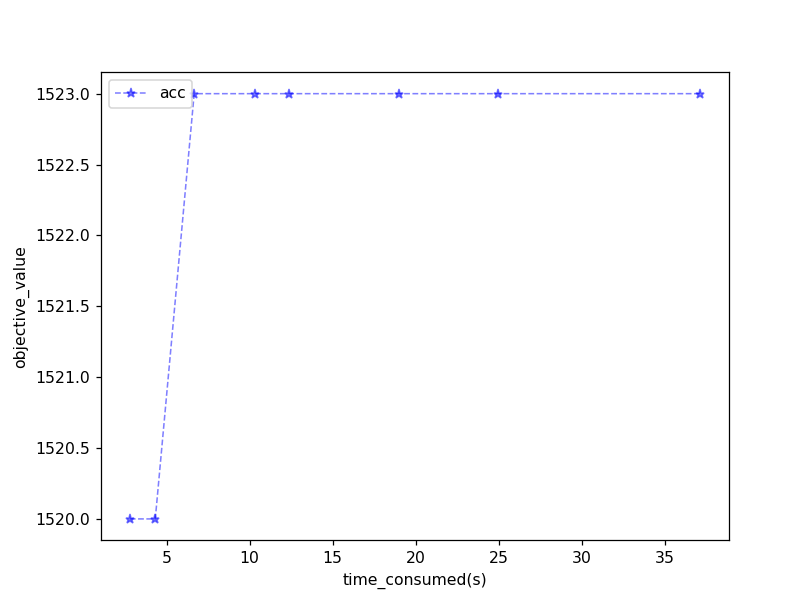

In [82]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(time_consume, objective_values, 'b*--', alpha=0.5, linewidth=1, label='acc')

plt.legend()  
plt.xlabel('time_consumed(s)') 
plt.ylabel('objective_value')
 
plt.show()

In [83]:
objective_values

[1520.0, 1520.0, 1523.0, 1523.0, 1523.0, 1523.0, 1523.0, 1523.0]

## Output Part:

In [45]:
best_set

{'routes': {0: ['G7', 'H7', 'E7', 'A7', 'C7'],
  1: ['H4', 'E4', 'C4', 'A4', 'A5'],
  2: ['A6', 'B6', 'D6', 'C6', 'E6'],
  3: ['G10', 'H10', 'H8', 'E8', 'F8', 'G8'],
  4: ['A1', 'C9', 'B9', 'C8', 'A8']},
 'overtime': [13.0, 17.0, 16.0, 0, 10.0],
 'requests': [44, 34, 42, 28, 34],
 'travelling_time': [45.0, 69.0, 52.0, 58.0, 62.0],
 'obj_value': 1534.0,
 'comp_time': 26.353828191757202}

In [46]:
# path of vehicles
paths=[]
for i in range(len(best_set['routes'])):
    paths.append(best_set['routes'][i])
best_set['routes']=paths
best_set['service_time']=[time*2 for time in best_set['requests']]

In [47]:
#chage a little bit format
best_set

{'routes': [['G7', 'H7', 'E7', 'A7', 'C7'],
  ['H4', 'E4', 'C4', 'A4', 'A5'],
  ['A6', 'B6', 'D6', 'C6', 'E6'],
  ['G10', 'H10', 'H8', 'E8', 'F8', 'G8'],
  ['A1', 'C9', 'B9', 'C8', 'A8']],
 'overtime': [13.0, 17.0, 16.0, 0, 10.0],
 'requests': [44, 34, 42, 28, 34],
 'travelling_time': [45.0, 69.0, 52.0, 58.0, 62.0],
 'obj_value': 1534.0,
 'comp_time': 26.353828191757202,
 'service_time': [88, 68, 84, 56, 68]}

<IPython.core.display.Javascript object>


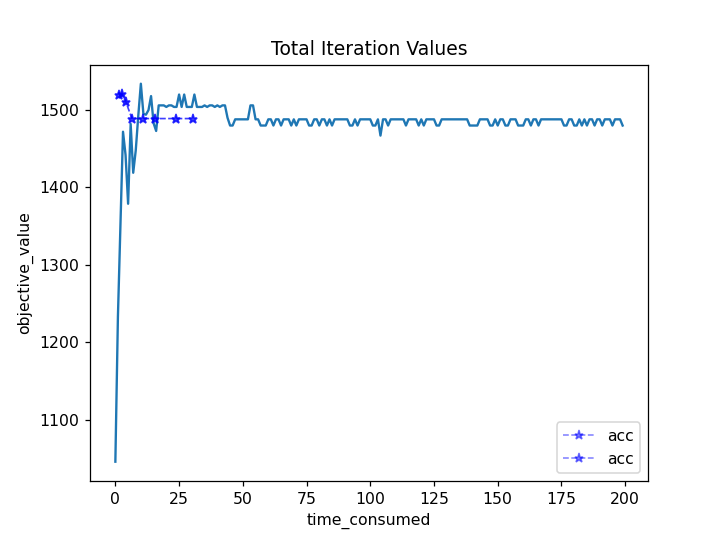

In [48]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(total_iter_value)
plt.title('Total Iteration Values')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

## Visualization the Route

<IPython.core.display.Javascript object>


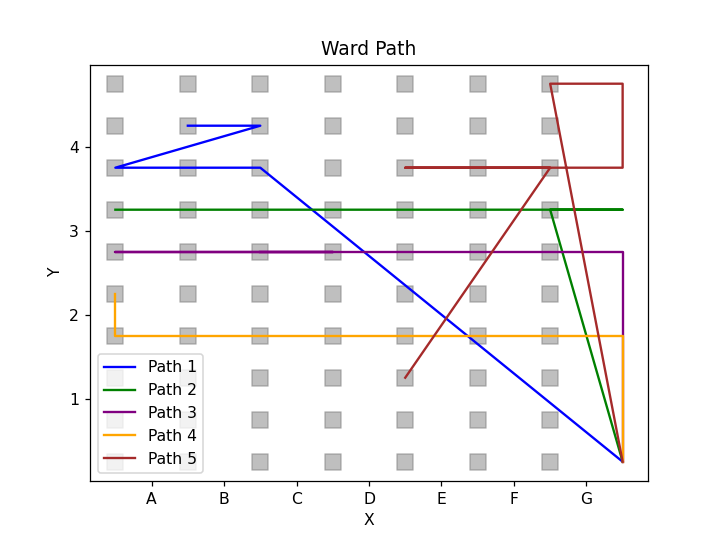

<ipython-input-65-6782403b065a>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', ''])
<ipython-input-65-6782403b065a>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])


In [65]:
#static solution map
import matplotlib.pyplot as plt

# 2d-map
ward_map = [['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-']]

# location of vehicles
door_locations = [('D', 6), ('D', 9), ('D', 4)]

# path of vehicles
paths=[]
for i in range(len(best_set['routes'])):
    paths.append([vehicle_depot[i]]+best_set['routes'][i])

# draw the map
fig, ax = plt.subplots()
for i in range(len(ward_map)):
    for j in range(len(ward_map[0])):
        if (i, j) in door_locations:
            ax.scatter(j + 0.5, i + 0.5, marker='*', s=1000, color='red')
        elif ward_map[i][j] == '-':
            ax.scatter(j + 0.5, i + 0.5, marker='s', s=100, color='gray', alpha=0.5)

colors = ['blue', 'green', 'purple', 'orange', 'brown']
for i, path in enumerate(paths):
    x = []
    y = []
    for p in path:
        x.append(ord(p[0]) - 65 + 0.5)
        y.append(int(p[1:]) - 0.5)
    ax.plot(x, y, color=colors[i], label='Path ' + str(i+1))

# add labels
ax.legend()
#plt.xticks(range(10))
#plt.yticks(range(15))
ax.set_xticklabels(['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', ''])
ax.set_yticklabels(['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ward Path')

plt.show()


<IPython.core.display.Javascript object>


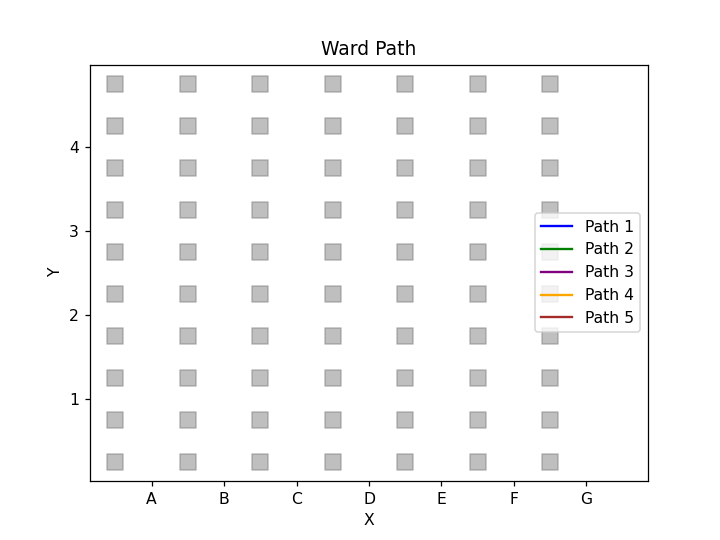

<ipython-input-51-5936108b59b8>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', ''])
<ipython-input-51-5936108b59b8>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])


In [51]:
#dynamic solution map
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 2d-map
ward_map = [['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-'],
            ['-', '-', '-', '-', '-', '-', '-']]

# location of each vehicle
door_locations = [('D', 6), ('D', 9), ('D', 4)]

# route of each vehicle
paths=[]
for i in range(len(best_set['routes'])):
    paths.append([vehicle_depot[i]]+best_set['routes'][i])

# initialize
fig, ax = plt.subplots()
for i in range(len(ward_map)):
    for j in range(len(ward_map[0])):
        if (i, j) in door_locations:
            ax.scatter(j + 0.5, i + 0.5, marker='*', s=1000, color='red')
        elif ward_map[i][j] == '-':
            ax.scatter(j + 0.5, i + 0.5, marker='s', s=100, color='gray', alpha=0.5)

colors = ['blue', 'green', 'purple', 'orange', 'brown']
lines = []
for i, path in enumerate(paths):
    x = []
    y = []
    for p in path:
        x.append(ord(p[0]) - 65 + 0.5)
        y.append(int(p[1:]) - 0.5)
    line, = ax.plot(x[:1], y[:1], color=colors[i], label='Path ' + str(i+1))
    lines.append(line)

# add labels
ax.legend()
ax.set_xticklabels(['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', ''])
ax.set_yticklabels(['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ward Path')

# update the animation
def update(frame):
    for i, path in enumerate(paths):
        if frame < len(path):
            x = [ord(p[0]) - 65 + 0.5 for p in path[:frame+1]]
            y = [int(p[1]) - 0.5 for p in path[:frame+1]]
            lines[i].set_xdata(x)
            lines[i].set_ydata(y)
    return lines

ani = animation.FuncAnimation(fig, update, frames=10, interval=1000, blit=True)

plt.show()

<IPython.core.display.Javascript object>


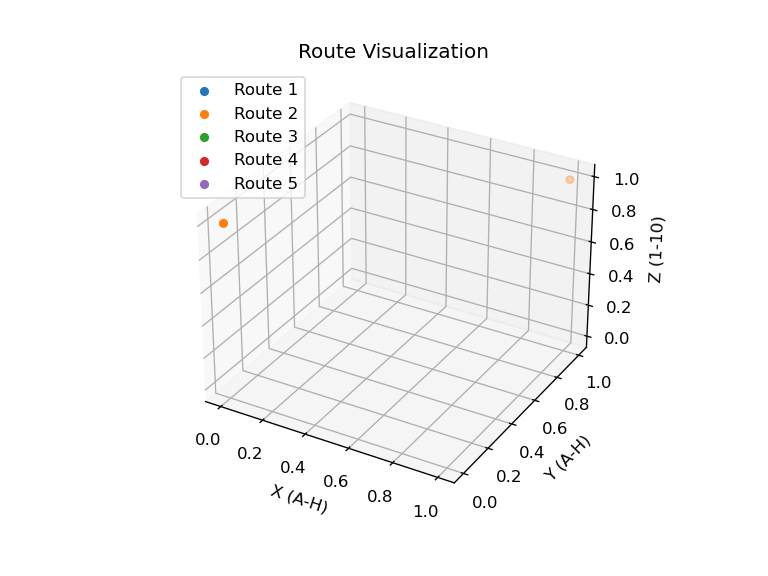

In [55]:
#---------not finished yet------------#
#3d-map
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# define routes
routes=[]
for i in range(len(best_set['routes'])):
    routes.append([vehicle_depot[i]]+best_set['routes'][i])
    
# add map
coords = {letter: index for index, letter in enumerate('ABCDEFGH')}

# add 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# major part
for i, route in enumerate(routes):
    x = []
    y = []
    z = []
    for pos in route:
        if len(pos) >= 3:
            x.append(coords[pos[0]])
            y.append(coords[pos[0]])
            z.append(int(pos[1]))
    ax.scatter(x, y, z, label='Route {}'.format(i+1))
    
# add labels
ax.set_xlabel('X (A-H)')
ax.set_ylabel('Y (A-H)')
ax.set_zlabel('Z (1-10)')
ax.set_title('Route Visualization')
ax.legend()

# show result
plt.show()


$$
p_{ij} = \frac{[\tau_{ij}(t)]^{\alpha}[\eta_{ij}]^{\beta}}{\sum_{k \in N_i} [\tau_{ik}(t)]^{\alpha}[\eta_{ik}]^{\beta}}
$$